# The Aim
Can we pick out 'food groups' or perhaps come up with new food groups via the use of clustering methods based on the nutrition breakdown of different food items?

In [7]:
import warnings
warnings.filterwarnings('ignore')

#Data Frames and data manipulation
import pandas as pd
import numpy as np

#Analysis and processing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#Visualisation
import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
#pylab.rcParams['figure.figsize'] = 15, 15  #Set the size of figures in notebook

After importing the necessary libraries, the data is read from a csv file into a dataframe, and doing some initial data preparation is carried out which includes:

- creating a subset with only the columns of interest - these include the features used to build the model.
- removing rows where data includes null numerical values for any of the nutrition columns
- filter by UK based foods (not necessarily needed by helps with the language differences)

In [2]:
df_raw = pd.read_csv(r"D:\Google Drive\kaggle\food\world-food-facts-release-2016-01-13-03-19-37\world-food-facts\FoodFacts.csv")

col_list = ['serving_size', 'product_name', 'generic_name', 'countries', 'energy_100g', 
            'fat_100g','carbohydrates_100g','sugars_100g','proteins_100g', 'salt_100g']

df = df_raw[col_list]

df = df[np.isfinite(df['salt_100g']) & np.isfinite(df['carbohydrates_100g']) & np.isfinite(df['fat_100g']) & 
        np.isfinite(df['proteins_100g']) & np.isfinite(df['energy_100g']) & np.isfinite(df['sugars_100g'])]
df = df[df.countries == ("United Kingdom" or "en:GB" or "en:UK")]

For clustering methods the input variables need to be in the form of a numpy array. 

In [3]:
carbs = df.carbohydrates_100g
fats = df.proteins_100g
protein = df.fat_100g
energy = df.energy_100g
sugar = df.sugars_100g
salt = df.salt_100g

food_array = np.array((sugar, protein, fats, carbs, salt))

food_array = food_array.T
#food_array = np.nan_to_num(food_array) 

Two methods of clustering are used: agglomerative and k means.

- Agglomerative clustering is a type of hierarchical which works on the basis of each data point representing its own cluster which then merges with the nearest cluster to form a new cluster. This is repeated until the desired number of clusters is reached.


- K means clustering assigns each data point to the nearest cluster centre (clusters can be initialised via a number of ways). Once each data point is assigned, a new cluster centre is calculated (based on the average position of all data within the cluster). The data are then reassigned to the nearest new cluster centre and the process is repeated until convergence is reached.

In [4]:
agglom = AgglomerativeClustering(n_clusters=5)
agglom.fit(food_array)
df["agglom_labels"] = agglom.labels_

k_means = KMeans(n_clusters=5)
k_means.fit(food_array)
df["k_means_labels"] = k_means.labels_

Two dictionaries are created storing a wordcloud object for each method. These are then used to produce wordcloud plots of product names for each cluster for each method. The size of the word relates to the frequency and thus gives a general sense of the food products included in each cluster.

In [5]:

#Create a label for the plots showing the average nutrition values for each cluster
agglom_averages = {}
for i in range(0, 5):
    agglom_averages["agglom{0}".format(i)] = [("P: "+ str((df.proteins_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("C: "+ str((df.carbohydrates_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("F: "+ str((df.fat_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("Su: "+ str((df.sugars_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("Sa: "+ str((df.salt_100g[df.agglom_labels == i]).mean().round(1)))]
    

k_means_averages = {}
for i in range(0, 5):
    k_means_averages["k_means{0}".format(i)] = [("P: "+ str((df.proteins_100g[df.k_means_labels == i]).mean().round(1))), 
                                              ("C: "+ str((df.carbohydrates_100g[df.k_means_labels == i]).mean().round(1))), 
                                              ("F: "+ str((df.fat_100g[df.k_means_labels == i]).mean().round(1))), 
                                              ("Su: "+ str((df.sugars_100g[df.k_means_labels == i]).mean().round(1))), 
                                              ("Sa: "+ str((df.salt_100g[df.k_means_labels == i]).mean().round(1)))]

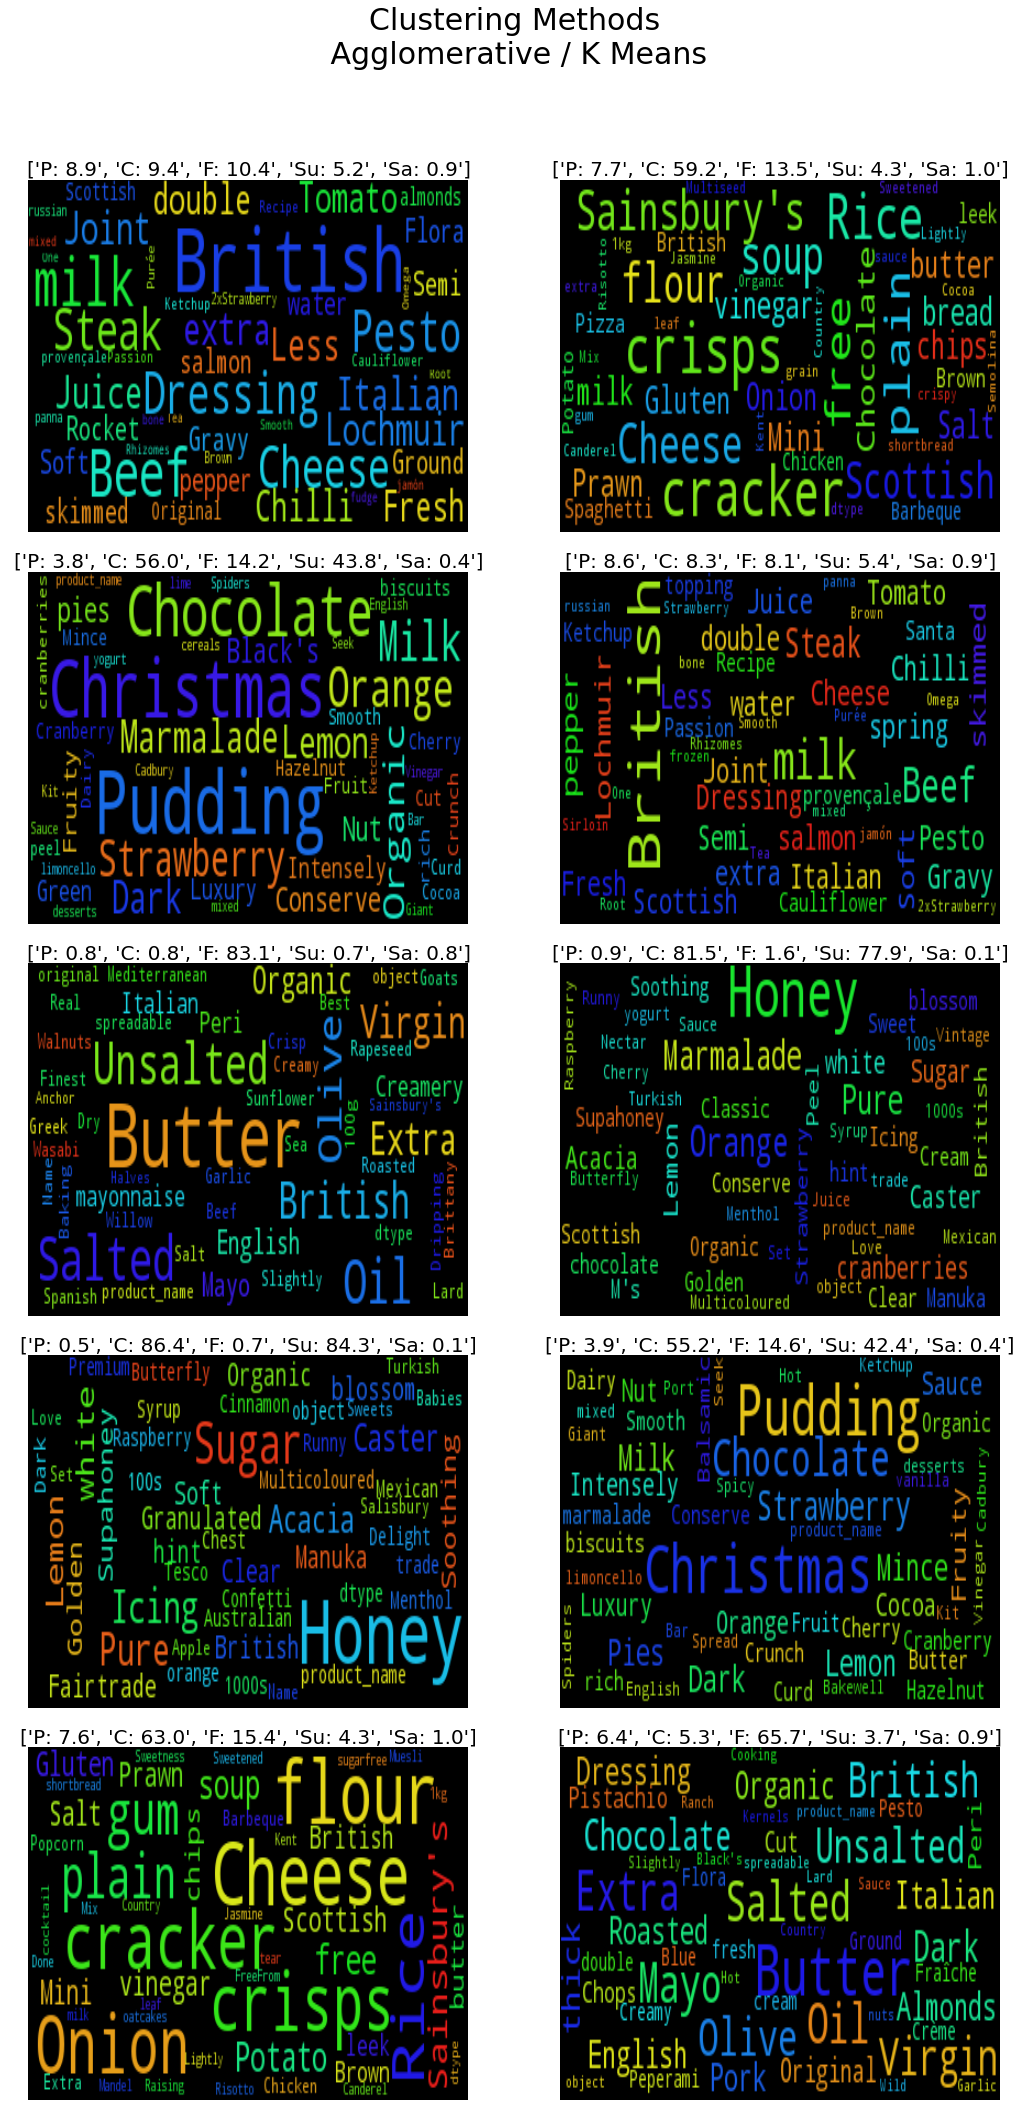

In [6]:
agglom_clusters = {}
for i in range(0, 5):
    agglom_clusters["agglom{0}".format(i)] = \
    WordCloud(max_font_size=50, relative_scaling = 0.5, max_words=50).generate(str(df.product_name[df.agglom_labels == i]))
    
k_means_clusters = {}
for i in range(0, 5):
    k_means_clusters["k_means{0}".format(i)] = \
    WordCloud(max_font_size=40, relative_scaling = 0.5, max_words=50).generate(str(df.product_name[df.k_means_labels == i]))
    
    
#plotting
f, axarr = plt.subplots(nrows = 5, ncols = 2,  figsize = (15,30))
f.suptitle("Clustering Methods \n Agglomerative / K Means", fontsize = 30)

axarr[0,0].set_title("Agglomerative", fontsize = 20)
axarr[0,1].set_title("K Means", fontsize = 20)

for i in range(0, 5):
    axarr[i, 0].imshow(agglom_clusters["agglom"+str(i)], aspect = "auto", interpolation=None)
    axarr[i, 0].axis("off")
    axarr[i, 0].set_title(agglom_averages["agglom"+str(i)],fontsize = 20)
    
    axarr[i, 1].imshow(k_means_clusters["k_means"+str(i)], aspect = "auto", interpolation=None)
    axarr[i, 1].axis("off")
    axarr[i, 1].set_title(k_means_averages["k_means"+str(i)],fontsize = 20)
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)

Plots show the most common words found in the product names for each cluster with the larger sized font relating to a higher frequency of the word. Values shown above the plot indicate the average protein, carb, fat, sugar, and salt breakdown per cluster (measured in g per 100g).

The cluster order is randomly generated so the left and right hand plots won’t necessarily be equivocal. However, we can see for the most part each cluster from one method has a comparable cluster using the other method, though there are some key differences.
For example, the clusters that contain 'oil' foods differ in that the K means method shows items such as nuts and meats appearing more prominently (larger font size) than with the agglomerative method.

To Do:

•	Proper comparison between similar clusters from each method (investigate disjoint set to see where clusters are differing in terms of food types).

•	Better characterise clusters.

•	Redo with fewer parameters so 2D cross plots can be used.

•	Expand on clustering methods (include images).